## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.optimize import fmin_cg
import time
from sklearn.datasets import fetch_california_housing

## GD, Newton, and CG

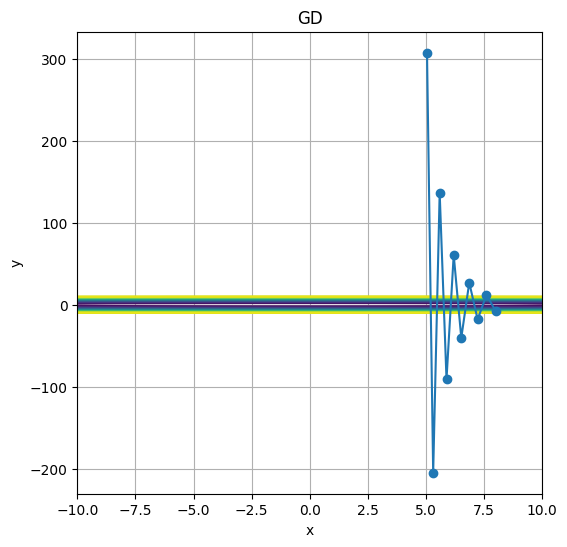

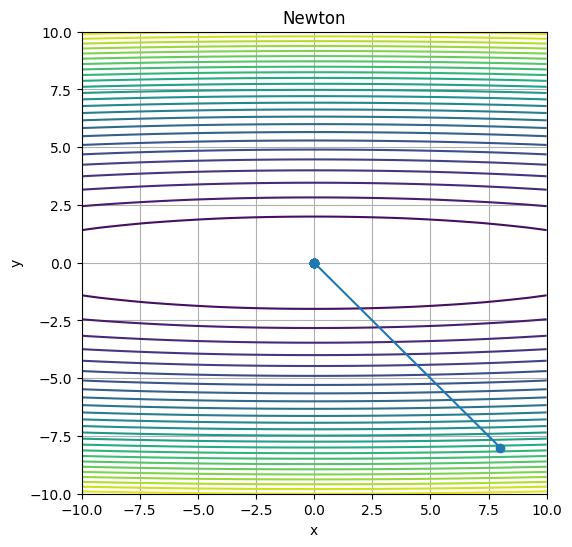

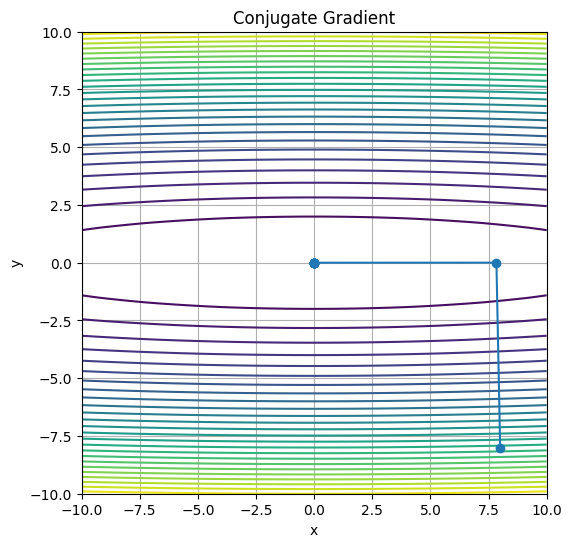

In [ ]:
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def grad(v):
    return H @ v

# Gradient Descent
def GD(v0, lr=0.01, iterations=10):
    vec = []
    v = v0
    for i in range(iterations):
        vec.append([v[0], v[1]])
        v = v - lr * grad(v)

    return np.array(vec)

# Newton
def Newton(v0, iterations=10):
    vec = []
    v = v0
    for i in range(iterations):
        vec.append([v[0], v[1]])
        v = v - np.linalg.inv(H) @ grad(v)

    return np.array(vec)

# Conjugate Gradient
def CG(v0, iterations=10):
    vec = []
    v = v0
    r = -grad(v)
    p = r

    for i in range(iterations):
        vec.append([v[0], v[1]])
        alpha = (r @ r) / (p @ H @ p)
        v = v + alpha * p

        r_new = r - alpha * (H @ p)
        beta = (r_new @ r_new) / (r @ r)
        p = r_new + beta * p
        r = r_new

    return np.array(vec)


def plot_contours():
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = 0.5*(X**2 + 50*Y**2)
    plt.contour(X, Y, Z, levels=30)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)


v0 = np.array([8.0, -8.0])

vec_gd = GD(v0, lr=0.05)
vec_newton = Newton(v0)
vec_cg = CG(v0)

# GD
plt.figure(figsize=(6,6))
plot_contours()
plt.plot(vec_gd[:,0], vec_gd[:,1], '-o')
plt.title("GD")
plt.savefig("GD.pdf")
plt.show()

# Newton
plt.figure(figsize=(6,6))
plot_contours()
plt.plot(vec_newton[:,0], vec_newton[:,1], '-o')
plt.title("Newton")
plt.savefig("Newton.pdf")
plt.show()

# CG
plt.figure(figsize=(6,6))
plot_contours()
plt.plot(vec_cg[:,0], vec_cg[:,1], '-o')
plt.title("Conjugate Gradient")
plt.savefig("CG.pdf")
plt.show()


## Shallow MLP

SGD: Accuracy=0.9825, Time=0.44s
L-BFGS: Accuracy=0.9708, Time=0.06s
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 66
         Function evaluations: 80500
         Gradient evaluations: 250
CG: Accuracy=0.9766, Time=26.79s


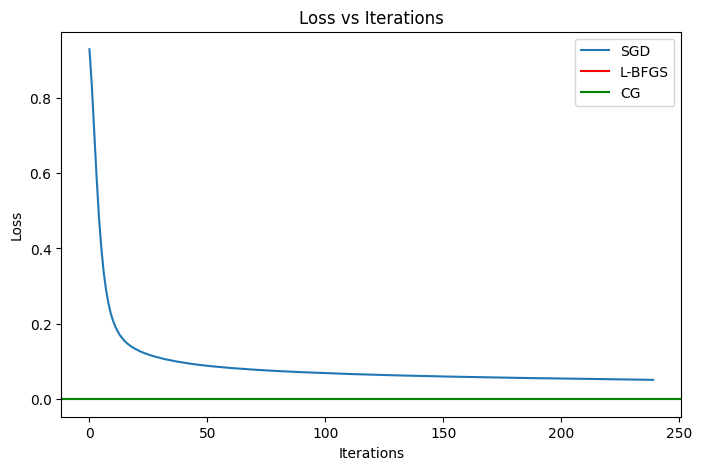

In [ ]:
# DataSet
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

input_dim = X_train.shape[1]
hidden_neurons = 10
output_neurons = 1
results = {}

# SGD
SGD = MLPClassifier(hidden_layer_sizes=(hidden_neurons,),
                        solver='sgd',
                        max_iter=1000,
                        learning_rate_init=0.01,
                        random_state=42,
                        verbose=False)
start = time.time()
SGD.fit(X_train, y_train)
end = time.time()
y_pred = SGD.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results['SGD'] = {'loss': SGD.loss_curve_, 'time': end-start, 'accuracy': accuracy}
print(f"SGD: Accuracy={accuracy:.4f}, Time={end-start:.2f}s")

# L-BFGS
LBFGS = MLPClassifier(hidden_layer_sizes=(hidden_neurons,),
                          solver='lbfgs',
                          max_iter=500,
                          random_state=42,
                          verbose=False)
start = time.time()
LBFGS.fit(X_train, y_train)
end = time.time()
y_pred = LBFGS.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results['LBFGS'] = {'loss': [LBFGS.loss_], 'time': end-start, 'accuracy': accuracy}
print(f"L-BFGS: Accuracy={accuracy:.4f}, Time={end-start:.2f}s")

# CG
def sigmoid(x):
    return 1/(1+np.exp(-x))

def flatten_params(W1, b1, W2, b2):
    return np.concatenate([W1.ravel(), b1.ravel(), W2.ravel(), b2.ravel()])

def unflatten_params(params):
    i = 0
    W1 = params[i:i+input_dim*hidden_neurons].reshape(input_dim, hidden_neurons)
    i += input_dim*hidden_neurons
    b1 = params[i:i+hidden_neurons]
    i += hidden_neurons
    W2 = params[i:i+hidden_neurons*output_neurons].reshape(hidden_neurons, output_neurons)
    i += hidden_neurons*output_neurons
    b2 = params[i:i+output_neurons]
    return W1, b1, W2, b2

def loss(params, X, y):
    W1, b1, W2, b2 = unflatten_params(params)
    z1 = X @ W1 + b1
    a1 = np.maximum(0, z1)
    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2).ravel()
    eps = 1e-8
    return -np.mean(y*np.log(a2+eps) + (1-y)*np.log(1-a2+eps))

# Initilize
np.random.seed(42)
W1 = np.random.randn(input_dim, hidden_neurons)*0.1
b1 = np.zeros(hidden_neurons)
W2 = np.random.randn(hidden_neurons, output_neurons)*0.1
b2 = np.zeros(output_neurons)
init_params = flatten_params(W1, b1, W2, b2)

# CG
start = time.time()
params_cg = fmin_cg(loss, init_params, args=(X_train, y_train), maxiter=200, disp=True)
end = time.time()

# CG
W1_cg, b1_cg, W2_cg, b2_cg = unflatten_params(params_cg)
a1 = np.maximum(0, X_test @ W1_cg + b1_cg)
a2 = sigmoid(a1 @ W2_cg + b2_cg).ravel()
y_pred_cg = (a2>0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_cg)
results['CG'] = {'loss':[loss(params_cg, X_train, y_train)], 'time':end-start, 'accuracy': accuracy}
print(f"CG: Accuracy={accuracy:.4f}, Time={end-start:.2f}s")

# Loss
plt.figure(figsize=(8,5))
plt.plot(results['SGD']['loss'], label='SGD')
plt.axhline(results['LBFGS']['loss'][0], color='r', label='L-BFGS')
plt.axhline(results['CG']['loss'][0], color='g', label='CG')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.savefig("Loss.pdf")
plt.show()


## Deep Neural Network

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of X_train: (60000, 784)
Shape of y_train: (60000, 10)
Total parameters: 44860
Hessian memory required: 7.50 GB


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
422/422 - 2s - 5ms/step - accuracy: 0.5029 - loss: 1.6311 - val_accuracy: 0.8218 - val_loss: 0.7978
Epoch 2/10
422/422 - 1s - 3ms/step - accuracy: 0.8355 - loss: 0.6154 - val_accuracy: 0.8910 - val_loss: 0.4085
Epoch 3/10
422/422 - 1s - 3ms/step - accuracy: 0.8772 - loss: 0.4304 - val_accuracy: 0.9103 - val_loss: 0.3292
Epoch 4/10
422/422 - 1s - 3ms/step - accuracy: 0.8928 - loss: 0.3690 - val_accuracy: 0.9178 - val_loss: 0.2893
Epoch 5/10
422/422 - 1s - 3ms/step - accuracy: 0.9034 - loss: 0.3326 - val_accuracy: 0.9258 - val_loss: 0.2609
Epoch 6/10
422/422 - 2s - 4ms/step - accuracy: 0.9114 - loss: 0.3069 - val_accuracy: 0.9295 - val_loss: 0.2431
Epoch 7/10
422/422 - 2s - 5ms/step - accuracy: 0.9176 - loss: 0.2868 - val_accuracy: 0.9350 - val_loss: 0.2301
Epoch 8/10
422/422 - 1s - 4ms/step - accuracy: 0.9231 - loss: 0.2702 - val_accuracy: 0.9367 - val_loss: 0.2165
Epoch 9/10
422/422 - 1s - 3ms/step - accuracy: 0.9266 - loss: 0.2565 - val_accuracy: 0.9438 - val_loss: 0.2049
E

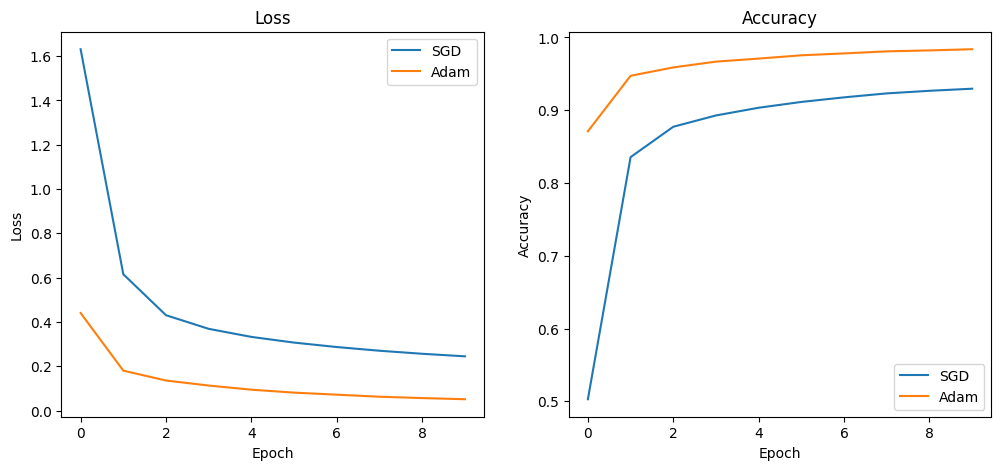

In [ ]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# DataSet
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train_cat.shape)

# Parameters
input_dim = X_train.shape[1]
hidden_neurons = 50
output_classes = 10

# Number of Parameters
params_layer1 = input_dim * hidden_neurons + hidden_neurons
params_layer2 = hidden_neurons * hidden_neurons + hidden_neurons
params_layer3 = hidden_neurons * hidden_neurons + hidden_neurons
params_out = hidden_neurons * output_classes + output_classes

total_params = params_layer1 + params_layer2 + params_layer3 + params_out
print(f"Total parameters: {total_params}")

# Hessian
hessian_elements = total_params**2
hessian_memory_bytes = hessian_elements * 4
hessian_memory_gb = hessian_memory_bytes / (1024**3)
print(f"Hessian memory required: {hessian_memory_gb:.2f} GB")

# SGD
model_sgd = Sequential([
    Dense(hidden_neurons, activation='relu', input_shape=(input_dim,)),
    Dense(hidden_neurons, activation='relu'),
    Dense(hidden_neurons, activation='relu'),
    Dense(output_classes, activation='softmax')
])
model_sgd.compile(optimizer=SGD(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history_sgd = model_sgd.fit(X_train, y_train_cat,
                            epochs=10, batch_size=128,
                            validation_split=0.1, verbose=2)

# Adam
model_adam = Sequential([
    Dense(hidden_neurons, activation='relu', input_shape=(input_dim,)),
    Dense(hidden_neurons, activation='relu'),
    Dense(hidden_neurons, activation='relu'),
    Dense(output_classes, activation='softmax')
])
model_adam.compile(optimizer=Adam(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
history_adam = model_adam.fit(X_train, y_train_cat,
                              epochs=10, batch_size=128,
                              validation_split=0.1, verbose=2)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_sgd.history['loss'], label='SGD')
plt.plot(history_adam.history['loss'], label='Adam')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_sgd.history['accuracy'], label='SGD')
plt.plot(history_adam.history['accuracy'], label='Adam')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("compare.pdf")
plt.show()


## QR

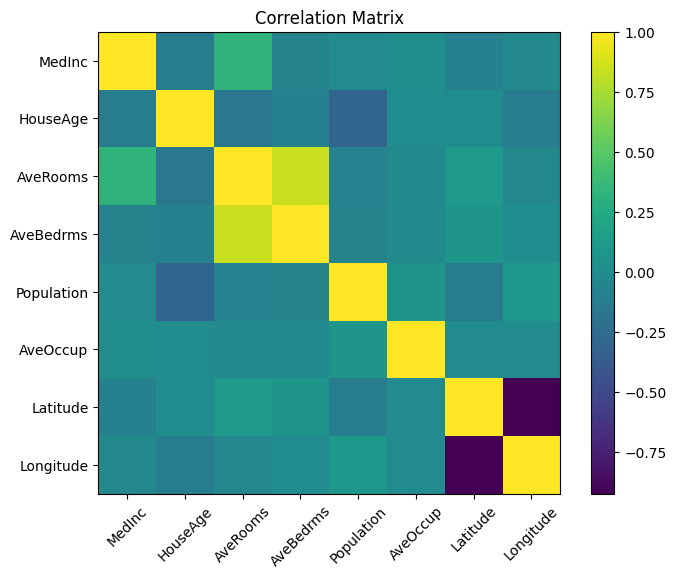

[[ 1. -0.  0. -0. -0.  0. -0.  0.]
 [-0.  1. -0.  0. -0.  0. -0.  0.]
 [ 0. -0.  1. -0. -0. -0.  0.  0.]
 [-0.  0. -0.  1. -0.  0. -0.  0.]
 [-0. -0. -0. -0.  1.  0.  0.  0.]
 [ 0.  0. -0.  0.  0.  1.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  1. -0.]
 [ 0.  0.  0.  0.  0. -0. -0.  1.]]


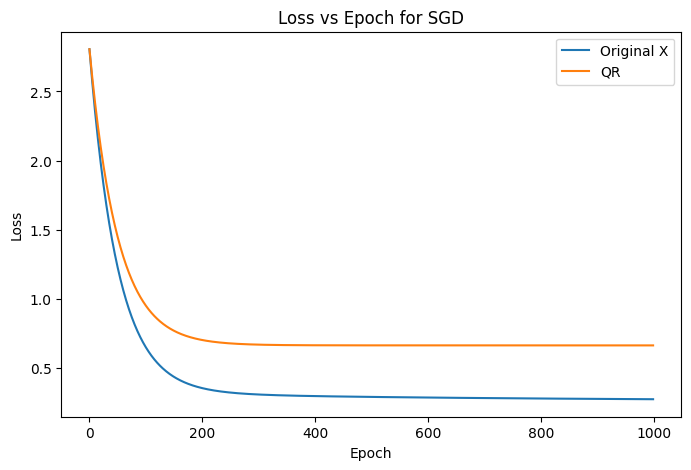

In [ ]:
# DataSet
housing = fetch_california_housing()
X, y = housing.data, housing.target
feature_names = housing.feature_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Matrix
corrolation = np.corrcoef(X_scaled.T)

plt.figure(figsize=(8,6))
plt.imshow(corrolation)
plt.colorbar()
plt.title("Correlation Matrix")
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(feature_names)), feature_names)
plt.savefig("correlation.pdf")
plt.show()

# Orthogonality
Q, R = np.linalg.qr(X_scaled)
print(np.round(Q.T @ Q, 2))

# Gradient Descent
def sgd_linear(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    loss_history = []

    for epoch in range(epochs):
        y_pred = X @ w + b
        error = y_pred - y
        loss = 0.5 * np.mean(error**2)
        loss_history.append(loss)

        grad_w = X.T @ error / n_samples
        grad_b = np.mean(error)
        w = w - lr * grad_w
        b = b - lr * grad_b

    return w, b, loss_history

# Train
w, b, loss = sgd_linear(X_scaled, y)
w_q, b_q, loss_q = sgd_linear(Q, y)

# Loss
plt.figure(figsize=(8,5))
plt.plot(loss, label='Original X')
plt.plot(loss_q, label='QR')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch for SGD")
plt.legend()
plt.savefig("Qrvsexact.pdf")
plt.show()
